In [1]:
import os
import math
import warnings
import operator
import pandas as pd
import numpy as np
import datetime as dt
import logging
import gcsfs
import statsmodels.api as sm

from pandas.io import gbq
from datetime import date, timedelta
from datetime import datetime
from google.cloud import storage
from IPython.display import display, HTML
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:.2f}'.format

In [2]:
df_ws = pd.read_csv('gs://aes-datahub-0001-raw/Weather/Weather_Source/USA/Indianapolis/Historical_Data/Storm_Data_2007-2019/Weather_Source_All_Marker.csv', index_col=0)
print(df_ws.shape)

(8500, 59)


In [3]:
print(list(df_ws.columns))

['cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'dewPtAvg', 'dewPtMax', 'dewPtMin', 'feelsLikeAvg', 'feelsLikeMax', 'feelsLikeMin', 'heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'latitude', 'longitude', 'mslPresAvg', 'mslPresMax', 'mslPresMin', 'precip', 'presTendAvg', 'presTendMax', 'presTendMin', 'radSolarAvg', 'radSolarMax', 'radSolarMin', 'radSolarTot', 'relHumAvg', 'relHumMax', 'relHumMin', 'sfcPresAvg', 'sfcPresMax', 'sfcPresMin', 'snowDepth', 'snowfall', 'spcHumAvg', 'spcHumMax', 'spcHumMin', 'tempAvg', 'tempMax', 'tempMin', 'timestamp', 'wetBulbAvg', 'wetBulbMax', 'wetBulbMin', 'windChillAvg', 'windChillMax', 'windChillMin', 'windDir100mAvg', 'windDir80mAvg', 'windDirAvg', 'windSpd100mAvg', 'windSpd100mMax', 'windSpd100mMin', 'windSpd80mAvg', 'windSpd80mMax', 'windSpd80mMin', 'windSpdAvg', 'windSpdMax', 'windSpdMin', 'Location']


In [4]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf_ws = df_ws.select_dtypes(include=numerics)

In [5]:
print(list(newdf_ws.columns))
newdf_ws.drop(['heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'latitude', 'longitude', 'mslPresAvg', 'mslPresMax', 'mslPresMin',
               'radSolarAvg', 'radSolarMax', 'radSolarMin', 'radSolarTot', 'snowDepth', 'wetBulbAvg', 'wetBulbMax', 'wetBulbMin',
               'windChillAvg', 'windChillMax', 'windChillMin', 'windDir100mAvg', 'windDir80mAvg', 'windSpd100mAvg', 'windSpd100mMax',
               'windSpd100mMin', 'windSpd80mAvg', 'windSpd80mMax', 'windSpd80mMin', 'spcHumAvg', 'spcHumMax', 'spcHumMin',
               'feelsLikeAvg', 'feelsLikeMax', 'feelsLikeMin','dewPtAvg', 'dewPtMax', 'dewPtMin', ], axis=1, inplace=True)

['cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'dewPtAvg', 'dewPtMax', 'dewPtMin', 'feelsLikeAvg', 'feelsLikeMax', 'feelsLikeMin', 'heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'latitude', 'longitude', 'mslPresAvg', 'mslPresMax', 'mslPresMin', 'precip', 'presTendAvg', 'presTendMax', 'presTendMin', 'radSolarAvg', 'radSolarMax', 'radSolarMin', 'radSolarTot', 'relHumAvg', 'relHumMax', 'relHumMin', 'sfcPresAvg', 'sfcPresMax', 'sfcPresMin', 'snowDepth', 'snowfall', 'spcHumAvg', 'spcHumMax', 'spcHumMin', 'tempAvg', 'tempMax', 'tempMin', 'wetBulbAvg', 'wetBulbMax', 'wetBulbMin', 'windChillAvg', 'windChillMax', 'windChillMin', 'windDir100mAvg', 'windDir80mAvg', 'windDirAvg', 'windSpd100mAvg', 'windSpd100mMax', 'windSpd100mMin', 'windSpd80mAvg', 'windSpd80mMax', 'windSpd80mMin', 'windSpdAvg', 'windSpdMax', 'windSpdMin']


In [6]:
print("Columns which have negative values :")
print('\n')
negative_list = list(newdf_ws.columns[(newdf_ws < 0).any()])
print(negative_list)

Columns which have negative values :


['presTendAvg', 'presTendMin', 'tempAvg', 'tempMax', 'tempMin']


In [7]:
## Add range for columns with negative values 

newdf_ws['presTendRange'] = newdf_ws['presTendMax'] - newdf_ws['presTendMin']
newdf_ws['tempRange'] = newdf_ws['tempMax'] - newdf_ws['tempMin']
newdf_ws['windSpdRange'] = newdf_ws['windSpdMax'] - newdf_ws['windSpdMin']
newdf_ws['sfcPresRange'] = newdf_ws['sfcPresMax'] - newdf_ws['sfcPresMin']
newdf_ws['cldCvrRange'] = newdf_ws['cldCvrMax'] - newdf_ws['cldCvrMin']
newdf_ws['relHumRange'] = newdf_ws['relHumMax'] - newdf_ws['relHumMin']


In [8]:
def diff(li1, li2): 
    return (list(set(li1) - set(li2))) 

print(diff(list(newdf_ws.columns), negative_list))

['cldCvrAvg', 'cldCvrRange', 'presTendRange', 'relHumRange', 'windSpdMin', 'windSpdMax', 'sfcPresMax', 'sfcPresMin', 'precip', 'presTendMax', 'windSpdRange', 'cldCvrMin', 'windSpdAvg', 'sfcPresAvg', 'sfcPresRange', 'relHumAvg', 'relHumMax', 'cldCvrMax', 'relHumMin', 'snowfall', 'windDirAvg', 'tempRange']


In [9]:
## Add ratio for columns which dont have negative values 


newdf_ws['relHumRatio'] = newdf_ws['relHumMax'] / newdf_ws['relHumMin']
newdf_ws['sfcPresRatio'] = newdf_ws['sfcPresMax'] / newdf_ws['sfcPresMin']

In [10]:
newdf_ws = newdf_ws.replace([np.inf, -np.inf], np.nan)
nulls = newdf_ws.isnull().sum()

df_nulls = pd.DataFrame({'Feature': nulls.index, 'VALUES': nulls.values})
df_nulls[df_nulls.VALUES>=1]

,Feature,VALUES


In [11]:
newdf_ws.head()

,cldCvrAvg,cldCvrMax,cldCvrMin,precip,presTendAvg,presTendMax,presTendMin,relHumAvg,relHumMax,relHumMin,sfcPresAvg,sfcPresMax,sfcPresMin,snowfall,tempAvg,tempMax,tempMin,windDirAvg,windSpdAvg,windSpdMax,windSpdMin,presTendRange,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio
0,69,100,6,0.82,-0.70,0.20,-3.00,79.30,87.30,67.30,988.70,995.20,977.50,0.10,30.10,38.20,21.40,109,19.90,29.90,13.10,3.20,16.80,16.80,17.70,94,20.00,1.30,1.02
1,45,100,1,0.16,-0.20,1.20,-2.20,65.00,79.30,47.10,981.90,986.40,977.20,0.00,65.40,77.70,49.30,213,15.50,21.50,9.10,3.40,28.40,12.40,9.20,99,32.20,1.68,1.01
2,93,100,60,0.92,-0.50,1.10,-2.00,78.00,89.10,65.00,970.80,980.50,964.80,0.00,46.60,56.90,38.70,143,15.40,21.10,10.60,3.10,18.20,10.50,15.70,40,24.10,1.37,1.02
3,13,32,2,0.00,-0.30,0.00,-1.20,53.70,73.60,32.00,982.40,985.40,979.00,0.00,76.80,88.20,66.30,211,5.90,12.00,1.90,1.20,21.90,10.10,6.40,30,41.60,2.30,1.01
4,41,90,9,0.02,-0.30,0.50,-0.90,65.00,84.90,46.00,974.50,978.70,971.90,0.00,72.00,80.60,66.40,236,4.70,11.90,0.30,1.40,14.20,11.60,6.80,81,38.90,1.85,1.01


In [12]:
df_ws = df_ws[['timestamp', 'Location']]

In [13]:
mergeddf = pd.merge(newdf_ws, df_ws, left_index=True, right_index=True)

In [14]:
mergeddf.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Test/Weather_Source_Data_v2.csv')

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(newdf_ws)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

In [17]:
type(vif)
df_vif = pd.DataFrame({'Feature': vif.index, 'VIF_SCORES': vif.values})
df_vif[df_vif.VIF_SCORES<=10]
# df_vif

,Feature,VIF_SCORES
1,cldCvrAvg,5.23
4,precip,1.57
5,presTendAvg,2.55
14,snowfall,1.19
18,windDirAvg,1.33


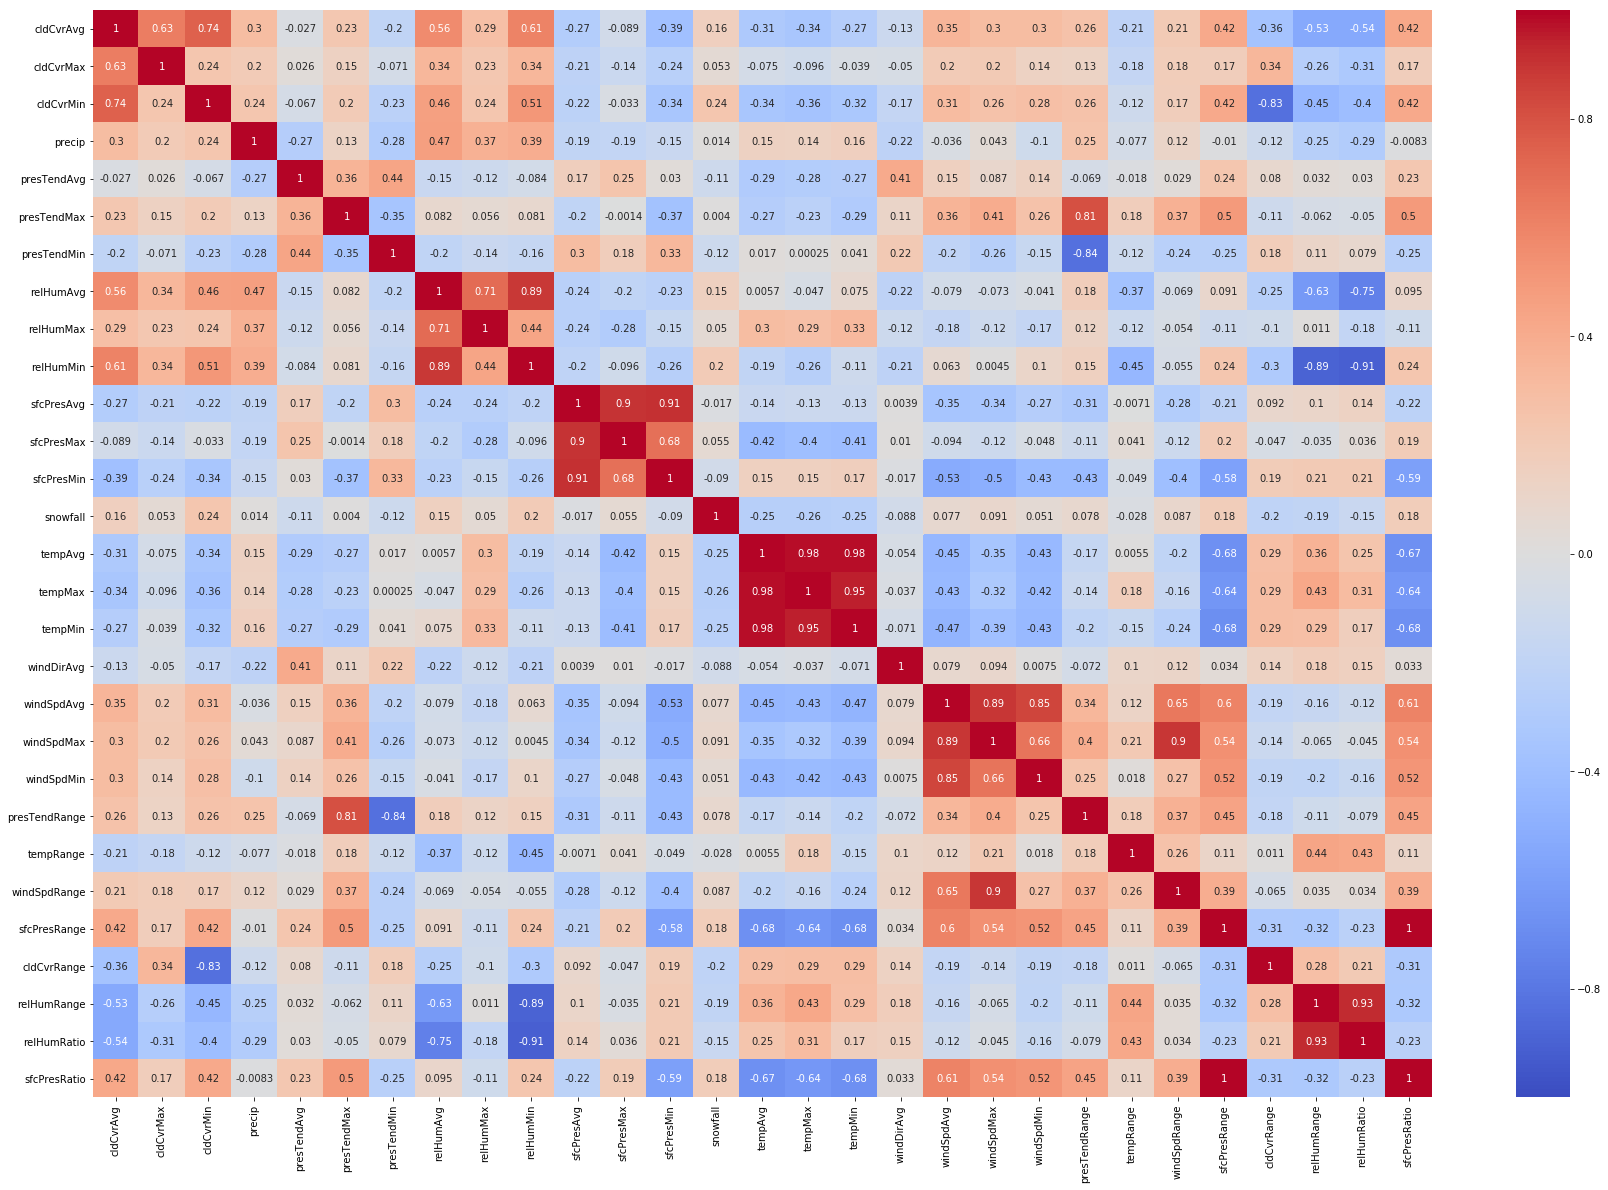

In [18]:
plt.figure(figsize=(30,20))
c= newdf_ws.corr()
sns.heatmap(c, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

In [19]:
newdf_ws.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Test/Weather_Source_Data.csv')